In [1]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from gensim.models import Word2Vec
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score

**Preparing Dataset**

In [2]:
df = pd.read_csv("../Dataset/training_set_rel3.tsv", sep='\t', encoding='ISO-8859-1');
df.dropna(axis=1,inplace=True)
df.drop(columns=['domain1_score','rater1_domain1','rater2_domain1'],inplace=True,axis=1)
df.head()
temp = pd.read_csv("Processed_data.csv")
temp.drop("Unnamed: 0",inplace=True,axis=1)

In [3]:
df['domain1_score']=temp['final_score']
df.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",6
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",7
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",5
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",8
4,5,1,"Dear @LOCATION1, I know having computers has a...",6


In [4]:
df['essay'][0]

"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the econom

In [5]:
temp.head(1)

,essay_id,essay_set,essay,final_score,clean_essay,char_count,word_count,sent_count,avg_word_len,spell_err_count,noun_count,adj_count,verb_count,adv_count
0,1,1,"Dear local newspaper, I think effects computer...",6,Dear local newspaper I think effects computer...,1441,344,16,4.188953,19,76,75,18,24


In [6]:
#Make Dataset
y = df['domain1_score']
df.drop('domain1_score',inplace=True,axis=1)
X=df

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
X_train.shape

(9083, 3)

**PREPROCESSING**

In [9]:
train_e = X_train['essay'].tolist()
test_e = X_test['essay'].tolist()

In [10]:
y_train

12481     6
6425      7
4989      7
12903     6
10239     8
         ..
11964     7
5191     10
5390      3
860       8
7270     10
Name: domain1_score, Length: 9083, dtype: int64

In [11]:
train_sents=[]
test_sents=[]

stop_words = set(stopwords.words('english')) 
def sent2word(x):
    x=re.sub("[^A-Za-z]"," ",x)
    x.lower()
    filtered_sentence = [] 
    words=x.split()
    for w in words:
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

def essay2word(essay):
    essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw = tokenizer.tokenize(essay)
    final_words=[]
    for i in raw:
        if(len(i)>0):
            final_words.append(sent2word(i))
    return final_words

for i in train_e:
    train_sents+=essay2word(i)

for i in test_e:
    test_sents+=essay2word(i)

In [12]:
len(train_sents)

115941

In [13]:
train_sents[0]

['It',
 'first',
 'day',
 'high',
 'school',
 'gut',
 'full',
 'butterflies',
 'make',
 'want',
 'run',
 'bathrooms',
 'hide',
 'world']

**Preparing WORD2VEC and LSTM Model**

In [14]:
def get_model():
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model

In [15]:
#Training Word2Vec model
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

model = Word2Vec(train_sents, 
                 workers=num_workers, 
                 vector_size=num_features, 
                 min_count = min_word_count, 
                 window = context, 
                 sample = downsampling)

# model.init_sims(replace=True)
model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

In [16]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [17]:
def makeVec(words, model, num_features):
    vec = np.zeros((num_features),dtype="float32")
    noOfWords = 0.
    index2word_set = set(model.wv.index_to_key)
    for i in words:
        if i in index2word_set:
            noOfWords += 1
            # vec = np.add(vec,model.wv[i])
            vec = np.add(vec,model.wv[i])
            # vec += model.wv[i].reshape((1, num_features))     
    vec = np.divide(vec,noOfWords)
    return vec


def getVecs(essays, model, num_features):
    c=0
    essay_vecs = np.zeros((len(essays),num_features),dtype="float32")
    for i in essays:
        essay_vecs[c] = makeVec(i, model, num_features)
        c+=1
    return essay_vecs


clean_train=[]
for i in train_e:
    clean_train.append(sent2word(i))
training_vectors = getVecs(clean_train, model, num_features)

clean_test=[]

for i in test_e:
    clean_test.append(sent2word(i))
testing_vectors = getVecs(clean_test, model, num_features)

In [18]:
training_vectors.shape

(9083, 300)

In [19]:
training_vectors = np.array(training_vectors)
testing_vectors = np.array(testing_vectors)

# Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
training_vectors = np.reshape(training_vectors, (training_vectors.shape[0], 1, training_vectors.shape[1]))
testing_vectors = np.reshape(testing_vectors, (testing_vectors.shape[0], 1, testing_vectors.shape[1]))
lstm_model = get_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 300)            721200    
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________


In [20]:
training_vectors.shape

(9083, 1, 300)


**TRAINING AND PREDICTION**







In [39]:
hist = lstm_model.fit(training_vectors, y_train, batch_size=64, epochs=150)

Epoch 1/150
142/142 [==============================] - 2s 17ms/step - loss: 1.5869 - mae: 0.9693
Epoch 2/150
142/142 [==============================] - 2s 16ms/step - loss: 1.5820 - mae: 0.9692
Epoch 3/150
142/142 [==============================] - 2s 17ms/step - loss: 1.5801 - mae: 0.9759
Epoch 4/150
142/142 [==============================] - 3s 18ms/step - loss: 1.5706 - mae: 0.9687
Epoch 5/150
142/142 [==============================] - 2s 17ms/step - loss: 1.6144 - mae: 0.9781
Epoch 6/150
142/142 [==============================] - 2s 16ms/step - loss: 1.5474 - mae: 0.9586
Epoch 7/150
142/142 [==============================] - 3s 18ms/step - loss: 1.5828 - mae: 0.9713
Epoch 8/150
142/142 [==============================] - 3s 18ms/step - loss: 1.5837 - mae: 0.9700
Epoch 9/150
142/142 [==============================] - 2s 17ms/step - loss: 1.5728 - mae: 0.9733
Epoch 10/150
142/142 [==============================] - 2s 16ms/step - loss: 1.6081 - mae: 0.9775
Epoch 11/150
142/142 [=======

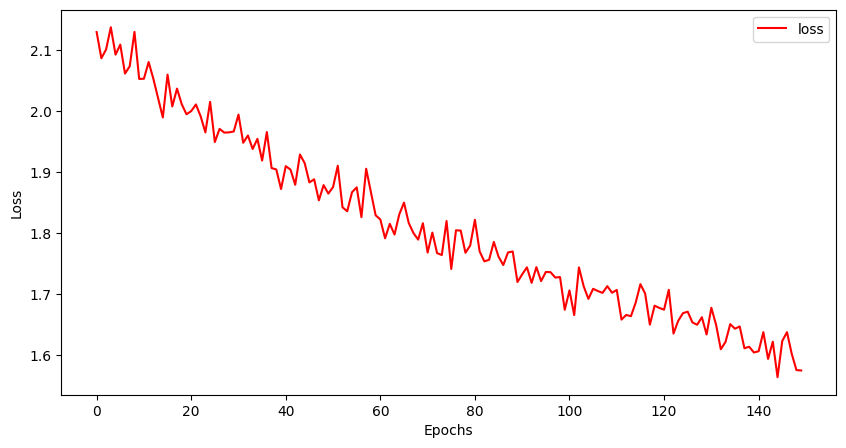

In [34]:
import matplotlib.pyplot as plt
fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))

hist_axes.clear()
hist_axes.plot(hist.history["loss"], label='loss', color='red')
hist_axes.set_xlabel('Epochs')
hist_axes.set_ylabel('Loss')
hist_axes.legend()

In [22]:
lstm_model.save('final_lstm.h5')

In [35]:
y_pred = lstm_model.predict(testing_vectors)
y_pred = np.around(y_pred)
y_pred

122/122 [==============================] - 1s 4ms/step


array([[2.],
       [6.],
       [7.],
       ...,
       [7.],
       [8.],
       [9.]], dtype=float32)

In [36]:
temp = y_pred.astype('int64')

In [37]:
temp

array([[2],
       [6],
       [7],
       ...,
       [7],
       [8],
       [9]], dtype=int64)

In [38]:
y_pred = np.around(y_pred)
result = cohen_kappa_score(y_test.values,temp,weights='quadratic')
print("Kappa Score: {}".format(result))
# results.append(result)

Kappa Score: 0.6966967724147173
